# Quantitative Spatial Economics (Summer Term 2024)
Humboldt University Berlin & Berlin School of Economics
Ahlfeldt, Herrera & Marczinek

Authors:
[Dominik Bursy](mailto:dominik.bursy@icloud.com),
[Lars Felder](),
[Marlon Krippendorf]()

Last Update: April 2024

---

## Tutorial Topic 1: Rosen-Roback

Context: In Topic 1, we cover the Rosen-Roback framework during the lecture. In this tutorial, we apply the logic of the spatial equilibrium framework to compute a quality-of-life (QoL) ranking for Germany counties (Kreise & kreisfreie Städte).

---

## Table of Contents

- [Import Packages](#packages)
- [1. Average Wage](#average_wage)
- [2. House Price Index](#house_price_index)
- [3. Exogenous Factors](#exogenous_factors)
- [Appendix](#appendix)

--- 

## References

- ...

---

## Import Packages <a class="anchor" id="packages"></a>

In [56]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS 

# import warnings
# warnings.filterwarnings('ignore')

# pd.set_option('display.max_columns', None)

savefigures = False

In [6]:
ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration


## 1. Average Wage <a class="anchor" id="average_wage"></a>

Prepare wage and worker data at a county level (Kreise) from the Federal Employment Agency for 2022, available in the course data repository (Repository/Data/county-wages-2022). Use the link provided there to check for more recent data. Extract wages and number of workers for workers i) without professional qualification ohneBerufsabschluss), ii)withrecognizedprofessionalqualification (anerkannter Berufsabschluss), iii) with academic degree (akademischer Berufsabschluss). Provide descriptive statistics and maps of these variables.

In [ ]:
gpd_germany_counties = gpd.read_file(f'{ROOT_FOLDER}/data/Shapefiles-2022/Germany/COUNTIES/VG250_KRS_clean_final.shp')
gpd_germany_counties = gpd_germany_counties[['county_id', 'GEN', 'EWZ', 'geometry']] 
gpd_germany_counties.rename(columns={'GEN': 'county_name', 'EWZ': 'population', 'KFL': 'county_area'}, inplace=True) 

In [25]:
# Extract wages and number of workers for workers 
# i) without professional qualification(ohne Berufsabschluss), 
# ii)with recognized professional qualification (anerkannter Berufsabschluss), 
# iii) with academic degree (akademischer Berufsabschluss). 

# wage_no_qualification
# wage_professional
# wage_academic

# df_wages.loc[df_wages['Unnamed: 2'] == 'ohne Berufsabschluss'].head(10)

# gpd_germany_counties['AGS'] = gpd_germany_counties['AGS'].astype('int64')
# gpd_germany_counties.join(df_fixed_effects.set_index('kid2019'), on='AGS')

df_wages = pd.read_excel(f'{ROOT_FOLDER}/data/county-wages-2022/country-wages-2022-entgelt-dwolk-0-202212-xlsx (1).xlsx',
              sheet_name='8.1', header=9)

In [26]:
gpd_germany_counties = gpd_germany_counties.join(
    df_wages.loc[df_wages['Unnamed: 2'] == 'ohne Berufsabschluss', ['Unnamed: 0', 1, 8]].set_index('Unnamed: 0'), 
    on='county_id').rename(columns={1: 'workers_no_qualification', 8: 'wage_no_qualification'})

gpd_germany_counties = gpd_germany_counties.join(
    df_wages.loc[df_wages['Unnamed: 2'] == 'anerkannter Berufsabschluss', ['Unnamed: 0', 1, 8]].set_index('Unnamed: 0'), 
    on='county_id').rename(columns={1: 'workers_professional', 8: 'wage_professional'})

gpd_germany_counties = gpd_germany_counties.join(
    df_wages.loc[df_wages['Unnamed: 2'] == 'akademischer Berufsabschluss', ['Unnamed: 0', 1, 8]].set_index('Unnamed: 0'), 
    on='county_id').rename(columns={1: 'workers_academic', 8: 'wage_academic'})

In [27]:
gpd_germany_counties.replace('X', np.nan, inplace=True)
gpd_germany_counties.replace('> 7.050', 7050, inplace=True)

gpd_germany_counties.iloc[:,5:] = gpd_germany_counties.iloc[:,5:].astype('float')

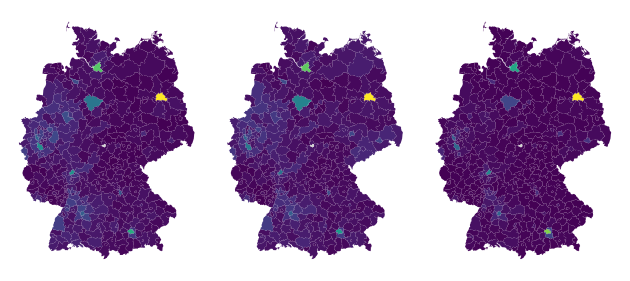

In [31]:
figure, axis = plt.subplots(1, 3)

gpd_germany_counties.plot(column='workers_no_qualification', ax=axis[0], missing_kwds={'color': 'lightgrey'})
gpd_germany_counties.plot(column='workers_professional', ax=axis[1], missing_kwds={'color': 'lightgrey'})
gpd_germany_counties.plot(column='workers_academic', ax=axis[2], missing_kwds={'color': 'lightgrey'})

axis[0].set_axis_off()
axis[1].set_axis_off()
axis[2].set_axis_off()

#figure.suptitle('Number of worker in Germany across Skill Groups')

plt.tight_layout()

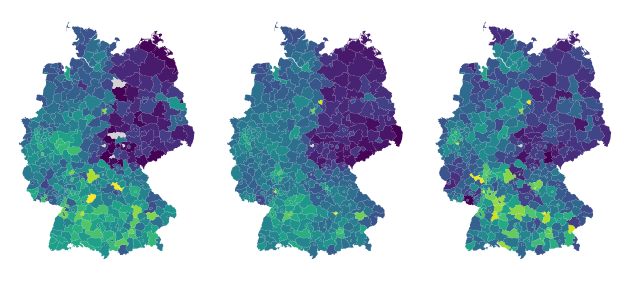

In [32]:
figure, axis = plt.subplots(1, 3)

gpd_germany_counties.plot(column='wage_no_qualification', ax=axis[0], missing_kwds={'color': 'lightgrey'})
gpd_germany_counties.plot(column='wage_professional', ax=axis[1], missing_kwds={'color': 'lightgrey'})
gpd_germany_counties.plot(column='wage_academic', ax=axis[2], missing_kwds={'color': 'lightgrey'})

axis[0].set_axis_off()
axis[1].set_axis_off()
axis[2].set_axis_off()

# figure.suptitle('Wages in Germany across Skill Groups')
# axis[0].set_title("Sine Function")

plt.tight_layout()

---

## 2. House Price Index <a class="anchor" id="house_price_index"></a>

Compute a mix-adjusted hedonic house price index at the county level using the RWI-FDZ cross-section campus data set (Data/RWI-GEO-RED-2022/cross_section). The standard way of creating a mix-adjusted price index is to adjust for observable characteristics in an “hedonic” regressions and recover fixed effects for the spatial units of interest. This can be done in a standard multivariate regression with the price per square meter on the left (in logs), relevant observable characteristics on the right, and county fixed effects. Estimate a parsimonious model focusing on the most important characteristics, less is usually more. Notice that the data set’s county (Kreis) identifier is “kid2019”. Generate one index of rental prices and another one for purchase prices. Provide descriptive statistics and maps of these variables. 

You can impute missing values with an auxiliary regression using the latest version of the Ahlfeldt-Heblich-Seidel county index available in the AHS2023 replication directory in the applications subfolder.

In [34]:
df_campus_wm = pd.read_csv(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/cross_section/CampusFile_WM_2022.csv', low_memory=False)

In [35]:
## Data Preparation 

# rent_sqm = mietekalt / wohnflaeche # df_campus_wm['wohnflaeche'] * df_campus_wm['rent_sqm']
# baujahr
# etage
# balkon 
# einbaukueche
# # df_campus_wm.baujahr.value_counts()

In [36]:
df_campus_wm.iloc[:,:10]

,obid,plz,mietekalt,nebenkosten,heizkosten,baujahr,letzte_modernisierung,wohnflaeche,nutzflaeche,etage
0,134064657,24937,455.0,111,Other missing,NaN,Other missing,63.000000,Other missing,0
1,138475785,24937,380.0,85,95,NaN,Other missing,58.369999,Other missing,1
2,136775842,24943,460.0,95,110,1980.0,Other missing,59.000000,Other missing,1
3,91272177,24937,726.0,160,160,NaN,Other missing,80.650002,30,2
4,138300121,24941,440.0,210,105,1955.0,Other missing,57.049999,Other missing,1
...,...,...,...,...,...,...,...,...,...,...
371098,126943233,4610,240.0,50,50,1965.0,Other missing,46.000000,Other missing,1
371099,130297181,4610,240.0,100,Other missing,1910.0,Other missing,43.000000,Other missing,Other missing
371100,130015818,4610,290.0,65.65000000000001,65.65000000000001,1954.0,Other missing,52.520000,Other missing,0
371101,123410330,4610,261.0,105,105,NaN,Other missing,52.410000,Other missing,3


In [37]:
df_campus_wm.iloc[:,10:20]

,anzahletagen,zimmeranzahl,nebenraeume,schlafzimmer,badezimmer,ev_kennwert,laufzeittage,hits,click_schnellkontakte,click_customer
0,0,3,Old variable (no longer part of the platform),Other missing,1,Other missing,14,927,16,Old variable (no longer part of the platform)
1,1,2,Old variable (no longer part of the platform),1,1,Other missing,16,1044,28,Old variable (no longer part of the platform)
2,Other missing,2,Old variable (no longer part of the platform),Other missing,Other missing,117,17,1852,73,Old variable (no longer part of the platform)
3,3,4,Old variable (no longer part of the platform),3,1,Other missing,47,2681,34,Old variable (no longer part of the platform)
4,Other missing,3,Old variable (no longer part of the platform),Other missing,Other missing,198.3999938964844,15,1651,76,Old variable (no longer part of the platform)
...,...,...,...,...,...,...,...,...,...,...
371098,Other missing,2,Old variable (no longer part of the platform),Other missing,1,98,548,337,5,Old variable (no longer part of the platform)
371099,Other missing,2,Old variable (no longer part of the platform),1,1,145.8000030517578,141,217,0,Old variable (no longer part of the platform)
371100,2,2,Old variable (no longer part of the platform),1,1,143.5,104,48,0,Old variable (no longer part of the platform)
371101,Other missing,2,Old variable (no longer part of the platform),Other missing,Other missing,87,431,137,0,Old variable (no longer part of the platform)


In [38]:
df_campus_wm.iloc[:,20:30]

,click_weitersagen,click_url,liste_show,liste_match,immobilientyp,aufzug,balkon,einbaukueche,ev_wwenthalten,foerderung
0,0,0,16416,112996,Flat-rent,No,Yes,Yes,Other missing,No
1,0,0,18965,63465,Flat-rent,No,No,Yes,Other missing,Yes
2,0,3,29683,80937,Flat-rent,No,Yes,No,Other missing,No
3,0,8,56173,216540,Flat-rent,No,Yes,Yes,Other missing,No
4,0,0,25273,65733,Flat-rent,No,No,Yes,Other missing,No
...,...,...,...,...,...,...,...,...,...,...
371098,0,0,6303,228606,Flat-rent,No,No,Yes,Yes,No
371099,0,0,7187,220902,Flat-rent,No,No,No,Other missing,No
371100,0,0,1187,23657,Flat-rent,No,Yes,No,Other missing,No
371101,0,0,2828,103994,Flat-rent,No,No,No,Other missing,No


In [39]:
df_campus_wm.iloc[:,30:40]

,gaestewc,garten,heizkosten_in_wm_enthalten,keller,parkplatz,rollstuhlgerecht,bauphase,ausstattung,energieeffizienzklasse,energieausweistyp
0,No,No,Yes,Yes,Other missing,Other missing,Variable for other types only,Sophisticated,Not specified,Not specified
1,No,No,No,No,Other missing,Other missing,Variable for other types only,Normal,Not specified,Not specified
2,No,No,No,No,Other missing,Other missing,Variable for other types only,Not specified,Not specified,Energy use [Energieverbauchskennwert]
3,No,No,No,Yes,Other missing,Other missing,Variable for other types only,Normal,Not specified,Not specified
4,No,No,Yes,Yes,No,Other missing,Variable for other types only,Not specified,Not specified,Energy demand [Energiebedarf]
...,...,...,...,...,...,...,...,...,...,...
371098,No,Yes,No,Yes,Other missing,Other missing,Variable for other types only,Normal,Not specified,Energy use [Energieverbauchskennwert]
371099,No,No,Yes,No,Other missing,Other missing,Variable for other types only,Not specified,Not specified,Energy demand [Energiebedarf]
371100,No,No,No,Yes,Other missing,Other missing,Variable for other types only,Normal,Not specified,Energy use [Energieverbauchskennwert]
371101,No,No,No,No,Other missing,Other missing,Variable for other types only,Not specified,Not specified,Energy use [Energieverbauchskennwert]


In [40]:
df_campus_wm.iloc[:,40:50]

,haustier_erlaubt,heizungsart,kategorie_Wohnung,objektzustand,lieferung,ergg_1km,blid,gid2019,kid2019,bef1
0,No,District heating,Other missing,Well kempt,Jun 2022,4285_3520,Schleswig Holstein,1001000,1001,NO_INFORMATION
1,By arrangement,District heating,Not specified,Needs renovation,Dec 2022,-9,Schleswig Holstein,1001000,1001,DISTRICT_HEATING
2,Not specified,Not specified,Not specified,Not specified,Dec 2022,-9,Schleswig Holstein,1001000,1001,DISTRICT_HEATING
3,By arrangement,District heating,Flat,Well kempt,Dec 2022,4283_3521,Schleswig Holstein,1001000,1001,DISTRICT_HEATING
4,Not specified,District heating,Flat,Not specified,Dec 2022,-9,Schleswig Holstein,1001000,1001,DISTRICT_HEATING
...,...,...,...,...,...,...,...,...,...,...
371098,Yes,Central heating,Flat,Well kempt,Dec 2022,4479_3108,The Free State of Thuringia,16077032,16077,DISTRICT_HEATING
371099,Not specified,Central heating,Flat,First occupancy,Jun 2022,4482_3106,The Free State of Thuringia,16077032,16077,Other missing
371100,By arrangement,District heating,Other missing,Modernised,Jun 2022,4480_3106,The Free State of Thuringia,16077032,16077,DISTRICT_HEATING
371101,Not specified,Central heating,Attic flat,Well kempt,Jun 2022,4481_3105,The Free State of Thuringia,16077032,16077,DISTRICT_HEATING


In [41]:
df_campus_wm.iloc[:,50:]

,bef2,bef10,bef9,bef8,bef7,bef6,bef5,bef4,bef3,anbieter,hits_gen,click_schnellkontakte_gen,click_weitersagen_gen,click_url_gen,liste_show_gen,liste_match_gen,adat,rent_sqm
0,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Private offer,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2022m5,7.222222
1,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Housing industry,65.250000,1.750000,0.000000,0.000000,1185.312500,3966.56250,2022m12,6.510194
2,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Real-estate agent,108.941180,4.294117,0.000000,0.176471,1746.058800,4761.00000,2022m9,7.796610
3,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Housing industry,968.239380,10.207627,0.099576,0.830508,19213.119000,59511.50400,2022m6,9.001860
4,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Builder,110.066670,5.066667,0.000000,0.000000,1684.866700,4382.20020,2022m12,7.712533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371098,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Real-estate agent,0.758573,0.007956,0.000000,0.000274,18.597805,469.70453,2021m3,5.217391
371099,DISTRICT_HEATING,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,GAS,Real-estate agent,1.098592,0.004695,0.000000,0.000000,31.361502,555.61505,2021m10,5.581395
371100,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Housing industry,2.140703,0.010050,0.000000,0.000000,55.075378,795.67841,2021m9,5.521706
371101,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Other missing,Real-estate agent,0.219109,0.002518,0.000000,0.000472,7.537699,110.37982,2020m10,4.979966


In [42]:
## Set target, features and fixed effects
target = ['rent_sqm'] 
features = ['baujahr', 'etage', 'zimmeranzahl']
features_binary = ['balkon', 'einbaukueche'] # aufzug, keller, parkplatz, ausstattung
fixed_effects = ['kid2019']

## Subset dataframe, drop missing values and index as panel dataset
data_regression = df_campus_wm[target + features + features_binary + fixed_effects]
data_regression = data_regression.set_index(fixed_effects + [data_regression.index])

data_regression.loc[data_regression['zimmeranzahl'] == 'Implausible value', 'zimmeranzahl'] = np.nan
data_regression.loc[data_regression['zimmeranzahl'].isna(), 'zimmeranzahl'] = data_regression['zimmeranzahl'].median()

data_regression.loc[data_regression['baujahr'].isna(), 'baujahr'] = data_regression['baujahr'].median()

data_regression.loc[data_regression['etage'] == 'Other missing', 'etage'] = np.nan
data_regression.loc[data_regression['etage'] == 'Implausible value', 'etage'] = np.nan
data_regression.loc[data_regression['etage'].isna()] = data_regression['etage'].median()
data_regression['etage'] = data_regression['etage'].astype(float)

data_regression.loc[data_regression['balkon'] == 'Other missing', 'balkon'] = 'No'
data_regression.loc[data_regression['einbaukueche'] == 'Other missing', 'einbaukueche'] = 'No'
data_regression['baujahr'] = data_regression['baujahr'].astype(float)

dummies1 = pd.get_dummies(data_regression['balkon'], prefix='balkon', drop_first=True)
dummies2 = pd.get_dummies(data_regression['einbaukueche'], prefix='einbaukueche', drop_first=True)
dummies = pd.concat([dummies1.iloc[:,[1]], dummies2.iloc[:,[1]]], axis=1)

## Set dependent and explainatory variables 
Y = data_regression[target]
X = pd.concat([data_regression[features], dummies], axis=1)
#X = data_regression[features]
X = sm.add_constant(X)


## Estimation of the firm fixed effects model
panel_ols_model = PanelOLS(Y, X, entity_effects=True, time_effects=False)
results_panel_ols_model = panel_ols_model.fit()
print(results_panel_ols_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:               rent_sqm   R-squared:                        0.6192
Estimator:                   PanelOLS   R-squared (Between):              0.1240
No. Observations:              371103   R-squared (Within):               0.6192
Date:                Mon, Apr 21 2025   R-squared (Overall):              0.4911
Time:                        12:56:24   Log-likelihood                -8.511e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.206e+05
Entities:                         380   P-value                           0.0000
Avg Obs:                       976.59   Distribution:                F(5,370718)
Min Obs:                       42.000                                           
Max Obs:                       7602.0   F-statistic (robust):          1.206e+05
                            

In [43]:
## Retrieve coefficients of firm fixed effects
df_fixed_effects = results_panel_ols_model.estimated_effects.reset_index().drop(columns='time').drop_duplicates(subset=['kid2019'])
df_fixed_effects['kid2019'] = df_fixed_effects['kid2019'].astype('object')

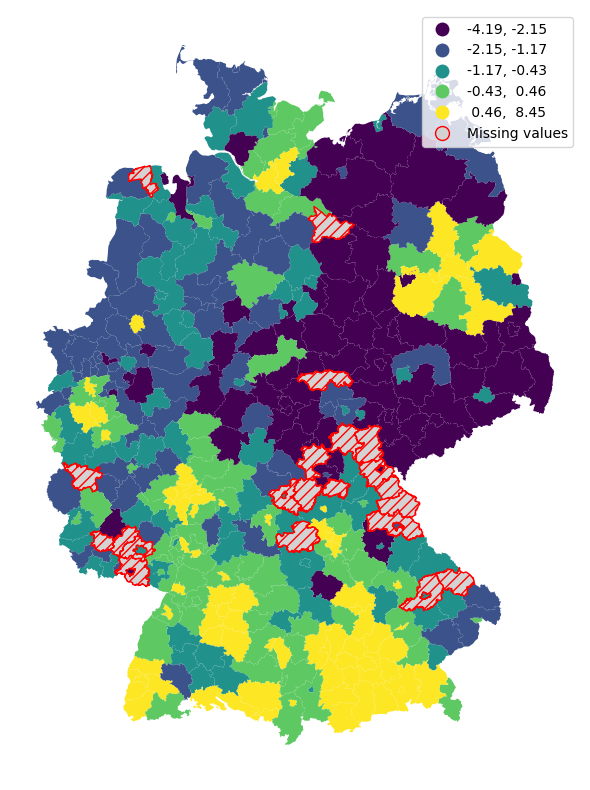

In [44]:
gpd_germany_counties['county_id'] = gpd_germany_counties['county_id'].astype('float')

gpd_germany_counties.join(df_fixed_effects.set_index('kid2019'), on='county_id').plot(
    column='estimated_effects', 
    legend=True,
    scheme="quantiles",
    figsize=(10, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
)
plt.axis('off');

---

In [46]:
df_campus_wk = pd.read_csv(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/cross_section/CampusFile_WK_2022.csv', low_memory=False)

In [49]:
## Set target, features and fixed effects
target = ['price_sqm'] 
features = ['baujahr', 'etage', 'zimmeranzahl']
features_binary = ['balkon', 'einbaukueche'] # aufzug, keller, parkplatz, ausstattung
fixed_effects = ['kid2019']

## Subset dataframe, drop missing values and index as panel dataset
data_regression = df_campus_wk[target + features + features_binary + fixed_effects]
data_regression = data_regression.set_index(fixed_effects + [data_regression.index])

data_regression.loc[data_regression['zimmeranzahl'] == 'Implausible value', 'zimmeranzahl'] = np.nan
data_regression.loc[data_regression['zimmeranzahl'].isna(), 'zimmeranzahl'] = data_regression['zimmeranzahl'].median()

data_regression.loc[data_regression['baujahr'].isna(), 'baujahr'] = data_regression['baujahr'].median()

data_regression.loc[data_regression['etage'] == 'Other missing', 'etage'] = np.nan
data_regression.loc[data_regression['etage'] == 'Implausible value', 'etage'] = np.nan
data_regression.loc[data_regression['etage'].isna()] = data_regression['etage'].median()
data_regression['etage'] = data_regression['etage'].astype(float)

data_regression.loc[data_regression['balkon'] == 'Other missing', 'balkon'] = 'No'
data_regression.loc[data_regression['einbaukueche'] == 'Other missing', 'einbaukueche'] = 'No'
data_regression['baujahr'] = data_regression['baujahr'].astype(float)

dummies1 = pd.get_dummies(data_regression['balkon'], prefix='balkon', drop_first=True)
dummies2 = pd.get_dummies(data_regression['einbaukueche'], prefix='einbaukueche', drop_first=True)
dummies = pd.concat([dummies1.iloc[:,[1]], dummies2.iloc[:,[1]]], axis=1)

## Set dependent and explainatory variables 
Y = data_regression[target]
X = pd.concat([data_regression[features], dummies], axis=1)
#X = data_regression[features]
X = sm.add_constant(X)


## Estimation of the firm fixed effects model
panel_ols_model = PanelOLS(Y, X, entity_effects=True, time_effects=False)
results_panel_ols_model = panel_ols_model.fit()
print(results_panel_ols_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:              price_sqm   R-squared:                        0.6903
Estimator:                   PanelOLS   R-squared (Between):              0.0637
No. Observations:              149747   R-squared (Within):               0.6903
Date:                Mon, Apr 21 2025   R-squared (Overall):              0.5887
Time:                        12:58:12   Log-likelihood                 -1.29e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   6.662e+04
Entities:                         327   P-value                           0.0000
Avg Obs:                       457.94   Distribution:                F(5,149415)
Min Obs:                       40.000                                           
Max Obs:                       5025.0   F-statistic (robust):          6.662e+04
                            

In [52]:
## Retrieve coefficients of firm fixed effects
df_fixed_effects = results_panel_ols_model.estimated_effects.reset_index().drop(columns='time').drop_duplicates(subset=['kid2019'])
df_fixed_effects['kid2019'] = df_fixed_effects['kid2019'].astype('object')

df_fixed_effects.rename(columns={'estimated_effects': 'purchase_index'}, inplace=True)

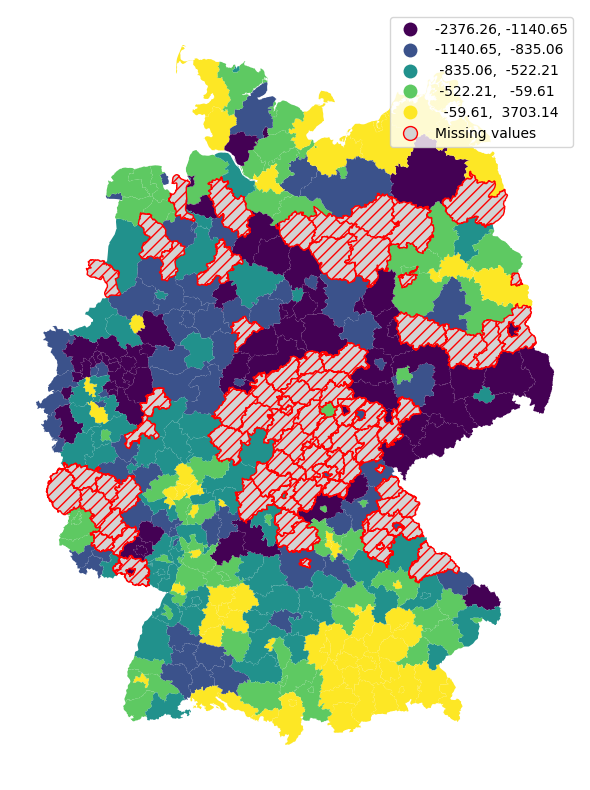

In [55]:
gpd_germany_counties['county_id'] = gpd_germany_counties['county_id'].astype('float')

gpd_germany_counties.join(df_fixed_effects.set_index('kid2019'), on='county_id').plot(
    column='purchase_index', 
    legend=True,
    scheme="quantiles",
    figsize=(10, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
)
plt.axis('off')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/purchase_index.png', bbox_inches='tight')
else:
    plt.tight_layout()

---

## 3. Exogenous Factors <a class="anchor" id="exogenous_factors"></a>

Refer to the quantitative framework based on Glaeser & Gottlieb (2009) introduced in the lecture.


- (a) Quality-of-life index

    Create a theory-consistent QoL index, Bc. Assume an expenditure share of housing of one-third in the baseline. Map the QoL index for all combinations of skill groups and price indices. Compute QoL rankings by skill groups and check for any interesting apparent patterns, regularities, and inconsistencies across groups and price indices. A county shapefile can be found here: Data/Shapefiles-2022/Germany/COUNTIES.

- (b) Fundamental productivity

    Create a theory-consistent fundamental productivity index, Ac. Assume an input share of labour of two-thirds. Hint: You will need to run some regression to recover the input share of capital. Map the productivity index and discuss the spatial pattern.

- (c) Effective land supply

    Create a theory-consistent measure of effective land supply, Mc. Assume a height elasticity of construction cost of 1.5. Map the land supply measure and discuss the spatial pattern. Bonus question: Can you think of a theory-consistent way of estimating the height elasticity of construction cost?

In [ ]:
## CODE HERE

---

## Appendix <a class="anchor" id="appendix"></a>

In [57]:
## CODE HERE

---